## Classification on 8 celebrities

In this notebook we try to classify images of : "Miranda_Cosgrove" "Chris_Martin" "Emma_Stone" "Jamie_Foxx" "Steve_Jobs" "Zac_Efron" "Sandra_Oh" "Taryn_Manning". There are 350 images of each celebrity, we use 250 for traning and 50 for validation and test.

In [1]:
#!pip3 install sklearn ##for docker users

In [2]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline
import h5py

Reading in the data, it is already prepared in a train, validation and testset. The class labels are form 0 to 7. The pixelsize of every image is 48x48 and we have 3 channels (RGB) per image. All 3 sets are balanced.

In [3]:
# Downloading the data, if it does not exist, this will take some time... (>120MB)
import urllib
import os
if not os.path.isfile('8_faces_train_and_valid.hdf5'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/dx03vk6dmbtoywn/8_faces_train_and_valid.hdf5?dl=1",
    "8_faces_train_and_valid.hdf5")

In [4]:
h5f_X = h5py.File('8_faces_train_and_valid.hdf5', 'r')
print(list(h5f_X.keys()))
X_train = h5f_X['X_train_8_faces']
print(X_train.shape)
Y_train = h5f_X['Y_train_8_faces']
print(Y_train.shape)
X_valid = h5f_X['X_valid_8_faces']
print(X_valid.shape)
Y_valid = h5f_X['Y_valid_8_faces']
print(Y_valid.shape)

['X_train_8_faces', 'X_valid_8_faces', 'Y_train_8_faces', 'Y_valid_8_faces']
(2000, 48, 48, 3)
(2000,)
(400, 48, 48, 3)
(400,)


(array([250., 250., 250., 250., 250., 250., 250., 250.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 8 Patch objects>)

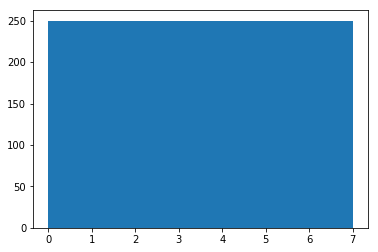

In [5]:
plt.hist(Y_train,bins=8)

(array([50., 50., 50., 50., 50., 50., 50., 50.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 8 Patch objects>)

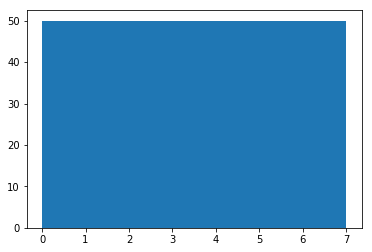

In [6]:
plt.hist(Y_valid,bins=8)

How hard is this task? Lets plot some random image of the trainset to get an impression of the images and of  the task. 

6


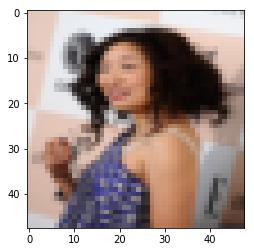

In [7]:
rmd=np.random.randint(0,len(X_train))
print(Y_train[rmd])
plt.imshow(np.asarray(X_train[rmd],dtype="uint8"))

#### Normalization of the training and validationset.

In [8]:
X_mean = np.mean( X_train, axis = 0)
X_std = np.std( X_train, axis = 0)

X_train = (X_train - X_mean ) / (X_std + 0.0001)
X_valid = (X_valid - X_mean ) / (X_std + 0.0001)

Define the convertToOneHot function and convert the labels into the onehot encoding.

In [9]:
def convertToOneHot(vector, num_classes=None):
    result = np.zeros((len(vector), num_classes), dtype='int32')
    result[np.arange(len(vector)), vector] = 1
    return result

In [10]:
Y_train=convertToOneHot(Y_train,num_classes=8)
Y_valid=convertToOneHot(Y_valid,num_classes=8)

In [11]:
print(Y_train[13])
print(Y_valid[13])

[0 0 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0]


### Define the network

In [12]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [13]:
model = Sequential()
name = 'cnn_8_faces'

model.add(Convolution2D(15, (3, 3),padding='same',input_shape=(48,48,3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(15, (3,3),padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(30, (3,3),padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(30, (3,3),padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4)))

model.add(Flatten())
model.add(Dense(300))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(8))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 15)        420       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 15)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 15)        2040      
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 15)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 15)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 30)        4080      
_________________________________________________________________
activation_3 (Activation)    (None, 24, 24, 30)        0         
__________

### Running a forward pass of the untrained network

In [15]:
model.evaluate(X_train,Y_train)

2000/2000 [==============================] - 6s 3ms/step


[2.1023138103485106, 0.128]

In [16]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir='tensorboard/8_faces/' + name + '/', 
        write_graph=True,
        histogram_freq=1)

In [17]:
os.makedirs("Checkpoints/8_faces/model_1_cnn/",exist_ok=True)       
checkpointer = keras.callbacks.ModelCheckpoint( 
        filepath =  "Checkpoints/8_faces/model_1_cnn/8_faces_cnn_"+"weights_epoch_{epoch:03d}-{val_loss:.2f}.hdf5",
        verbose = 1, 
        save_best_only = False,
        period = 5 )

### Training the network

In [18]:
history=model.fit(X_train, Y_train, 
                  batch_size=64, 
                  epochs=80,
                  verbose=1,
                  shuffle=True,
                  validation_data=(X_valid, Y_valid),
                  callbacks=[tensorboard,checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 400 samples
Epoch 1/80
2000/2000 [==============================] - 12s 6ms/step - loss: 2.2916 - acc: 0.1990 - val_loss: 1.9029 - val_acc: 0.3100
Epoch 2/80
2000/2000 [==============================] - 11s 6ms/step - loss: 1.9778 - acc: 0.3120 - val_loss: 1.7971 - val_acc: 0.3925
Epoch 3/80
2000/2000 [==============================] - 11s 6ms/step - loss: 1.7827 - acc: 0.3590 - val_loss: 1.9101 - val_acc: 0.3400
Epoch 4/80
2000/2000 [==============================] - 15s 8ms/step - loss: 1.6517 - acc: 0.4135 - val_loss: 1.5944 - val_acc: 0.4150
Epoch 5/80
2000/2000 [==============================] - 12s 6ms/step - loss: 1.5243 - acc: 0.4635 - val_loss: 1.6407 - val_acc: 0.4500

Epoch 00005: saving model to Checkpoints/8_faces/model_1_cnn/8_faces_cnn_weights_epoch_005-1.64.hdf5
Epoch 6/80
2000/2000 [==============================] - 11s 6ms/step - loss: 1.4645 - acc: 0.4740 - val_loss: 1.5091 - val_acc: 

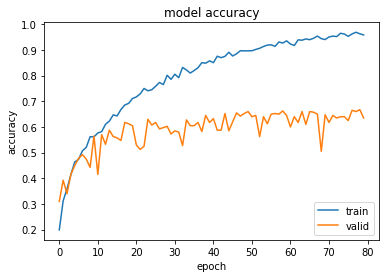

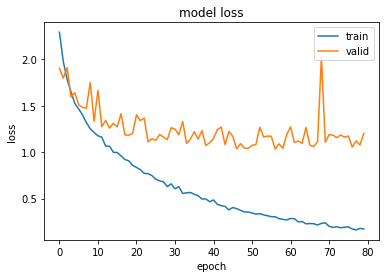

In [19]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Evaluation of the trained network

In [20]:
#load a saved model
from keras.models import load_model
model = load_model("Checkpoints/8_faces/model_1_cnn/8_faces_cnn_weights_epoch_050-1.04.hdf5")

In [21]:
preds=model.predict(X_valid)

In [22]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(np.argmax(Y_valid,axis=1),np.argmax(preds,axis=1)))
print("Acc = " ,np.sum(np.argmax(Y_valid,axis=1)==np.argmax(preds,axis=1))/len(preds))

[[39  1  1  3  2  0  3  1]
 [ 2 28  0  9  1  7  1  2]
 [ 3  4 31  3  0  2  0  7]
 [ 0  7  1 38  1  1  1  1]
 [ 0  8  0  0 40  0  0  2]
 [ 0  9  0  4  0 33  2  2]
 [11  3  0  3  4  2 25  2]
 [ 2  6  3  4  3  2  0 30]]
Acc =  0.66


### Evaluation on the test set

In [23]:
# Downloading the data, if it does not exist
if not os.path.isfile('8_faces_test.hdf5'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/ugxrdo0lpc2ixvr/8_faces_test.hdf5?dl=1",
    "8_faces_test.hdf5")

In [24]:
h5f_X = h5py.File('8_faces_test.hdf5', 'r')
print(list(h5f_X.keys()))
X_test = h5f_X['X_test_8_faces']
print(X_test.shape)
Y_test = h5f_X['Y_test_8_faces']
print(Y_test.shape)

['X_test_8_faces', 'Y_test_8_faces']
(400, 48, 48, 3)
(400,)


In [25]:
X_test = (X_test - X_mean ) / (X_std + 0.0001)

In [26]:
preds_test=model.predict(X_test)

In [27]:
print(confusion_matrix(Y_test[:],np.argmax(preds_test,axis=1)))
print("Acc = " ,np.sum(Y_test[:]==np.argmax(preds_test,axis=1))/len(preds_test))

[[39  2  1  2  0  1  4  1]
 [ 0 26  3  4  6  5  4  2]
 [ 2  2 34  2  1  2  1  6]
 [ 2  5  1 35  0  4  1  2]
 [ 0  3  0  2 43  1  0  1]
 [ 0  8  1  2  0 31  4  4]
 [ 6  3  1  2  1  1 33  3]
 [ 2  7  6  1  2  4  2 26]]
Acc =  0.6675
